# Load Data

In [1]:
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import scipy.stats
from pathlib import Path
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import matplotlib.patches as patches

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load embeddings and aligned data

In [2]:
embeddings = torch.load("SHINE embeddings.pt")
emb_combined = embeddings['emb_combined']
emb_recon_transcript = embeddings['emb_recon_transcript']
emb_recon_metabolite = embeddings['emb_recon_metabolite']
emb_latent_transcript = embeddings['emb_latent_transcript']
emb_latent_metabolite = embeddings['emb_latent_metabolite']

In [3]:
transcript_info = pd.read_csv("aligned_ST_data.csv")
transcript_expr = transcript_info.iloc[:, 3:]
print(transcript_expr)
genes = transcript_expr.columns
genes

      St18  2610203C22Rik       Vxn      Sgk3     Prex2  Mcm3  Tram2  \
0      0.0            0.0  0.000000  0.000000  0.000000   0.0    0.0   
1      0.0            0.0  1.524587  1.028412  1.028412   0.0    0.0   
2      0.0            0.0  1.944711  0.000000  0.000000   0.0    0.0   
3      0.0            0.0  0.000000  0.000000  0.000000   0.0    0.0   
4      0.0            0.0  0.000000  0.000000  0.000000   0.0    0.0   
...    ...            ...       ...       ...       ...   ...    ...   
2849   0.0            0.0  0.000000  0.000000  0.000000   0.0    0.0   
2850   0.0            0.0  1.410590  0.000000  0.935774   0.0    0.0   
2851   0.0            0.0  0.000000  0.000000  0.000000   0.0    0.0   
2852   0.0            0.0  0.000000  0.000000  0.000000   0.0    0.0   
2853   0.0            0.0  0.478684  0.000000  0.801058   0.0    0.0   

         Rims1  Gm29506  Fam178b  ...  Kctd12b  Ptchd1  Adgrg2      Ace2  \
0     1.704094      0.0      0.0  ...      0.0     0.0     

Index(['St18', '2610203C22Rik', 'Vxn', 'Sgk3', 'Prex2', 'Mcm3', 'Tram2',
       'Rims1', 'Gm29506', 'Fam178b',
       ...
       'Kctd12b', 'Ptchd1', 'Adgrg2', 'Ace2', 'Piga', 'Mospd2', 'Gpm6b',
       'mt-Co2', 'mt-Atp6', 'Tmlhe'],
      dtype='object', length=2000)

In [4]:
metabolite_info = pd.read_csv("aligned_SM_data.csv")
metabolite_abundance = metabolite_info.iloc[:, 3:]
print(metabolite_abundance)
metabolites = metabolite_abundance.columns
metabolites

      130.05041  132.07691  132.077165  133.074345  133.08065  136.01592  \
0      1.429279   3.579703    4.706287    0.816340   1.692314   1.451122   
1      0.610072   2.979343    3.829608    0.383907   0.921569   1.474011   
2      0.349708   2.320402    3.072067    0.000000   0.502025   1.558466   
3      1.297743   3.363405    4.526945    0.830513   1.513347   0.950779   
4      1.089108   3.530304    4.254096    0.549997   1.476565   1.130205   
...         ...        ...         ...         ...        ...        ...   
2849   1.187880   3.573240    4.503697    0.660361   1.552867   1.167462   
2850   1.506983   3.432162    4.749078    0.793382   1.779316   1.352624   
2851   1.340906   3.438788    4.570479    0.881970   1.618121   1.063376   
2852   1.468646   3.323619    4.611303    0.708309   1.623893   1.724168   
2853   0.974204   2.778708    3.661852    0.160573   0.816209   1.756511   

      136.048655  136.06234  136.52141  137.023795  ...  985.53971  \
0       1.420798 

Index(['130.05041', '132.07691', '132.077165', '133.074345', '133.08065',
       '136.01592', '136.048655', '136.06234', '136.52141', '137.023795',
       ...
       '985.53971', '985.9457150000001', '986.58098', '989.5183649999999',
       '990.4988149999999', '991.50214', '992.560465', '992.614545',
       '994.56201', '996.51046'],
      dtype='object', length=2754)

In [5]:
# Load original Visium AnnData
visium_path = Path("V11L12-038_A1/output_data/V11L12-038_A1_RNA/outs")
adata = sc.read_visium(path=visium_path)
adata.var_names_make_unique()

# Load matched transcript and metabolite info
transcript_info = pd.read_csv("aligned_ST_data.csv", index_col='spot')

barcodes_filtered = transcript_info.index.intersection(adata.obs_names)
adata_filtered = adata[barcodes_filtered, :].copy()

transcript_info = transcript_info.loc[barcodes_filtered, :]
adata_filtered = adata_filtered[transcript_info.index, :]

adata_filtered.obsm['spatial'] = adata_filtered.obsm['spatial']
adata_filtered

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2854 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
assert emb_combined.shape[0] == adata_filtered.n_obs, "Mismatch in combined embedding rows!"

for factor_idx in range(emb_combined.shape[1]):
    adata_filtered.obs[f'latent_combined_{factor_idx+1}'] = emb_combined[:, factor_idx]

print(adata_filtered.obs.iloc[:, -10:].head())
adata_filtered

                    latent_combined_247  latent_combined_248  \
AAACAAGTATCTCCCA-1             0.010629                  0.0   
AAACAGCTTTCAGAAG-1             0.010656                  0.0   
AAACAGGGTCTATATT-1             0.010696                  0.0   
AAACATTTCCCGGATT-1             0.010311                  0.0   
AAACCCGAACGAAATC-1             0.010874                  0.0   

                    latent_combined_249  latent_combined_250  \
AAACAAGTATCTCCCA-1                  0.0             0.081707   
AAACAGCTTTCAGAAG-1                  0.0             0.081235   
AAACAGGGTCTATATT-1                  0.0             0.080552   
AAACATTTCCCGGATT-1                  0.0             0.081833   
AAACCCGAACGAAATC-1                  0.0             0.081430   

                    latent_combined_251  latent_combined_252  \
AAACAAGTATCTCCCA-1             0.120015             0.030574   
AAACAGCTTTCAGAAG-1             0.119633             0.030678   
AAACAGGGTCTATATT-1             0.12027

AnnData object with n_obs × n_vars = 2854 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'latent_combined_1', 'latent_combined_2', 'latent_combined_3', 'latent_combined_4', 'latent_combined_5', 'latent_combined_6', 'latent_combined_7', 'latent_combined_8', 'latent_combined_9', 'latent_combined_10', 'latent_combined_11', 'latent_combined_12', 'latent_combined_13', 'latent_combined_14', 'latent_combined_15', 'latent_combined_16', 'latent_combined_17', 'latent_combined_18', 'latent_combined_19', 'latent_combined_20', 'latent_combined_21', 'latent_combined_22', 'latent_combined_23', 'latent_combined_24', 'latent_combined_25', 'latent_combined_26', 'latent_combined_27', 'latent_combined_28', 'latent_combined_29', 'latent_combined_30', 'latent_combined_31', 'latent_combined_32', 'latent_combined_33', 'latent_combined_34', 'latent_combined_35', 'latent_combined_36', 'latent_combined_37', 'latent_combined_38', 'latent_combined_39', 'latent_combined_40', 'latent_combined_41', 'latent_c

In [7]:
for factor_idx in range(emb_combined.shape[1]):
    adata_filtered.obs[f'latent_combined_{factor_idx}'] = emb_combined[:, factor_idx]

adata_filtered.obs.head()


,in_tissue,array_row,array_col,latent_combined_1,latent_combined_2,latent_combined_3,latent_combined_4,latent_combined_5,latent_combined_6,latent_combined_7,...,latent_combined_248,latent_combined_249,latent_combined_250,latent_combined_251,latent_combined_252,latent_combined_253,latent_combined_254,latent_combined_255,latent_combined_256,latent_combined_0
AAACAAGTATCTCCCA-1,1,50,102,0.078091,0.096975,0.038843,0.008934,0.0,0.028264,0.0,...,0.0,0.081707,0.120015,0.030574,0.106485,0.0,0.0,0.039031,0.039031,0.0
AAACAGCTTTCAGAAG-1,1,43,9,0.078806,0.097461,0.038269,0.009242,0.0,0.027410,0.0,...,0.0,0.081235,0.119633,0.030678,0.106454,0.0,0.0,0.039083,0.039083,0.0
AAACAGGGTCTATATT-1,1,47,13,0.078688,0.096923,0.037966,0.009057,0.0,0.027247,0.0,...,0.0,0.080552,0.120273,0.031114,0.106645,0.0,0.0,0.038672,0.038672,0.0
AAACATTTCCCGGATT-1,1,61,97,0.078723,0.097532,0.038631,0.009112,0.0,0.026854,0.0,...,0.0,0.081833,0.119889,0.030099,0.106495,0.0,0.0,0.039620,0.039620,0.0
AAACCCGAACGAAATC-1,1,45,115,0.078727,0.096671,0.038519,0.008982,0.0,0.028331,0.0,...,0.0,0.081430,0.119520,0.030175,0.106376,0.0,0.0,0.038740,0.038740,0.0


## Annotation

In [8]:
# Load RegionLoupe labels
loupe_df = pd.read_csv(f"{visium_path}/RegionLoupe.csv")

# Rename Barcode column for consistency
loupe_df.rename(columns={'Barcode': 'barcode'}, inplace=True)

# Set barcode as index
loupe_df.set_index('barcode', inplace=True)

# Filter loupe_df to match adata_filtered.obs barcodes exactly
loupe_df_filtered = loupe_df.loc[adata_filtered.obs_names, :]

# Merge RegionLoupe labels into adata_filtered.obs
adata_filtered.obs = adata_filtered.obs.join(loupe_df_filtered, how='left')

# Check integration result
print(adata_filtered.obs.head())

                    in_tissue  array_row  array_col  latent_combined_1  \
AAACAAGTATCTCCCA-1          1         50        102           0.078091   
AAACAGCTTTCAGAAG-1          1         43          9           0.078806   
AAACAGGGTCTATATT-1          1         47         13           0.078688   
AAACATTTCCCGGATT-1          1         61         97           0.078723   
AAACCCGAACGAAATC-1          1         45        115           0.078727   

                    latent_combined_2  latent_combined_3  latent_combined_4  \
AAACAAGTATCTCCCA-1           0.096975           0.038843           0.008934   
AAACAGCTTTCAGAAG-1           0.097461           0.038269           0.009242   
AAACAGGGTCTATATT-1           0.096923           0.037966           0.009057   
AAACATTTCCCGGATT-1           0.097532           0.038631           0.009112   
AAACCCGAACGAAATC-1           0.096671           0.038519           0.008982   

                    latent_combined_5  latent_combined_6  latent_combined_7  \
A

In [9]:
import pandas as pd

# Load Zeisel cell type prediction results
celltype_df = pd.read_csv("Zeisel_stsc_output.csv")

# Inspect the data structure
print(celltype_df.head())

# Keep only entries with barcodes ending in "_6"
celltype_df = celltype_df[celltype_df["Unnamed: 0"].str.endswith("_1")].copy()

# Remove the suffix "_6" to match barcodes in adata
celltype_df["barcode"] = celltype_df["Unnamed: 0"].str.replace("_1$", "", regex=True)

# Set barcode as the index
celltype_df.set_index("barcode", inplace=True)

# Assign the cell type with the highest predicted probability for each barcode
celltype_df["Cell type"] = celltype_df.iloc[:, 1:].idxmax(axis=1)

# Keep only the final cell type annotation
celltype_df = celltype_df[["Cell type"]]

celltype_df


             Unnamed: 0  Astrocytes  Cerebellum.neurons  \
0  TGGACCACGGCGTTGA-1_1    0.102054        1.795040e-11   
1  GCGGTAACCCAAATGA-1_1    0.115910        1.512089e-12   
2  CTAGATAAACTCCTCG-1_1    0.046326        1.394800e-02   
3  CTGGCTCCTGCGGGAT-1_1    0.077347        6.072674e-13   
4  GTATGACGTGGGAAAC-1_1    0.160772        7.925794e-02   

   Cholinergic.and.monoaminergic.neurons  \
0                           1.536204e-12   
1                           1.488970e-12   
2                           4.341540e-12   
3                           5.510188e-02   
4                           1.054869e-12   

   Cholinergic.and.monoaminergic.neurons.MBDOP1  \
0                                  8.743466e-13   
1                                  6.018266e-13   
2                                  7.575323e-13   
3                                  9.079394e-13   
4                                  5.987073e-13   

   Cholinergic.and.monoaminergic.neurons.MBDOP2  Choroid.epithelial.cells

,Cell type
barcode,
TGGACCACGGCGTTGA-1,Glutamatergic.neuroblasts
GCGGTAACCCAAATGA-1,Telencephalon.projecting.excitatory.neurons
CTAGATAAACTCCTCG-1,Telencephalon.projecting.excitatory.neurons
CTGGCTCCTGCGGGAT-1,Telencephalon.projecting.excitatory.neurons
GTATGACGTGGGAAAC-1,Telencephalon.projecting.excitatory.neurons
...,...
TCATGGAGGCCTTTGT-1,Telencephalon.projecting.excitatory.neurons
ATGGCCCGAAAGGTTA-1,Telencephalon.projecting.excitatory.neurons
CGTAATATGGCCCTTG-1,Telencephalon.projecting.excitatory.neurons


In [10]:
# Filter celltype_df to match adata_filtered.obs barcodes exactly
celltype_df_filtered = celltype_df.loc[adata_filtered.obs_names, :]

# Merge RegionLoupe labels into adata_filtered.obs
adata_filtered.obs = adata_filtered.obs.join(celltype_df_filtered, how='left')

# Check integration result
adata_filtered

AnnData object with n_obs × n_vars = 2854 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'latent_combined_1', 'latent_combined_2', 'latent_combined_3', 'latent_combined_4', 'latent_combined_5', 'latent_combined_6', 'latent_combined_7', 'latent_combined_8', 'latent_combined_9', 'latent_combined_10', 'latent_combined_11', 'latent_combined_12', 'latent_combined_13', 'latent_combined_14', 'latent_combined_15', 'latent_combined_16', 'latent_combined_17', 'latent_combined_18', 'latent_combined_19', 'latent_combined_20', 'latent_combined_21', 'latent_combined_22', 'latent_combined_23', 'latent_combined_24', 'latent_combined_25', 'latent_combined_26', 'latent_combined_27', 'latent_combined_28', 'latent_combined_29', 'latent_combined_30', 'latent_combined_31', 'latent_combined_32', 'latent_combined_33', 'latent_combined_34', 'latent_combined_35', 'latent_combined_36', 'latent_combined_37', 'latent_combined_38', 'latent_combined_39', 'latent_combined_40', 'latent_combined_41', 'latent_c

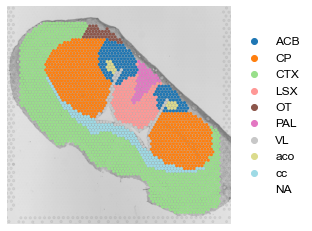

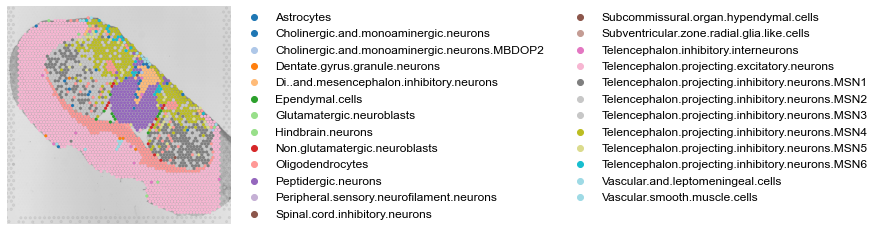

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['legend.fontsize'] = 12  

# RegionLoupe figure
axs = sc.pl.spatial(
    adata_filtered,
    img_key="hires",
    color="RegionLoupe",
    size=1.5,
    palette='tab20',
    alpha_img=0.6,
    bw=True,
    show=False,
    title=""
)

for ax in axs:
    ax.axis('off')

# plt.savefig('RegionLoupe.svg', format='svg', bbox_inches='tight')
plt.show()

# Cell type figure
axs = sc.pl.spatial(
    adata_filtered,
    img_key="hires",
    color="Cell type",
    size=1.5,
    palette='tab20',
    alpha_img=0.6,
    bw=True,
    show=False,
    title=""
)

for ax in axs:
    ax.axis('off')

plt.savefig('CellType.svg', format='svg', bbox_inches='tight')
plt.show()


# Clustering

## ST latent embedding

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


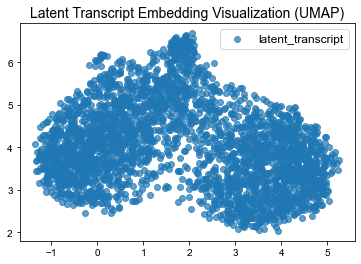

In [12]:
# Initialize the UMAP reducer
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Perform UMAP dimensionality reduction
reduced_latent_transcript_umap = umap_reducer.fit_transform(emb_latent_transcript)

# Plot the UMAP embedding
plt.scatter(
    reduced_latent_transcript_umap[:, 0],
    reduced_latent_transcript_umap[:, 1],
    label="latent_transcript",
    alpha=0.7
)
plt.legend()
plt.title("Latent Transcript Embedding Visualization (UMAP)")
plt.show()

# Store the UMAP embedding in adata if needed
adata = adata_filtered
adata.obsm["umap_latent_transcript"] = reduced_latent_transcript_umap


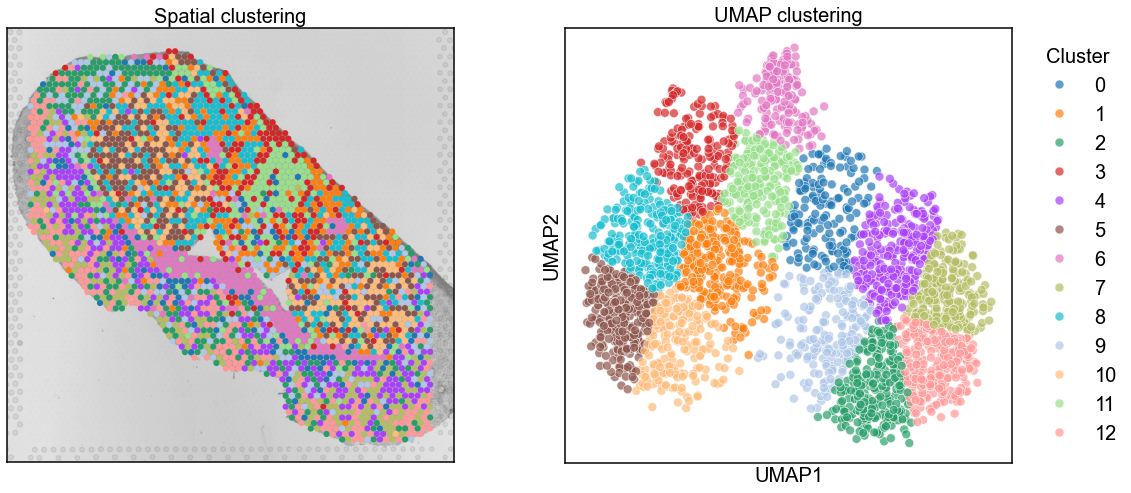

In [13]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 20

n_clusters = 13

X = adata.obsm['umap_latent_transcript']

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
adata.obs['umap_based_clusters'] = clusters.astype(str)

palette = sc.pl.palettes.default_20[:n_clusters]

fig, axes = plt.subplots(
    1, 2,
    figsize=(18, 8),
    gridspec_kw={'wspace': 0.25}
)

# ======================
# Panel 1: Spatial clustering
# ======================
sc.pl.spatial(
    adata,
    color='umap_based_clusters',
    palette=palette,
    size=1.5,
    bw=True,
    alpha_img=0.6,
    ax=axes[0],
    show=False,
    legend_loc=None,
    title="Spatial clustering"
)

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')

for spine in axes[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# ======================
# Panel 2: UMAP scatter (Seaborn)
# ======================
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=adata.obs['umap_based_clusters'],
    palette=palette,
    s=80,
    alpha=0.7,
    ax=axes[1],
    legend='full'
)

axes[1].set_title("UMAP clustering")
axes[1].set_xlabel("UMAP1")
axes[1].set_ylabel("UMAP2")
axes[1].set_xticks([])
axes[1].set_yticks([])

for spine in axes[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(
    handles,
    labels,
    title="Cluster",
    title_fontsize='medium',
    fontsize='medium',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.savefig(
    'ST_latent_spatial_umap.svg',
    format='svg',
    bbox_inches='tight'
)

plt.show()


In [14]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Embedding used for clustering evaluation
X = adata.obsm["umap_latent_transcript"]

# Cluster assignments
labels = adata.obs["umap_based_clusters"].astype(int)

# Silhouette score
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Calinski–Harabasz index
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

# Davies–Bouldin index
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.3f}")

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Filter out spots with missing RegionLoupe annotations
valid_idx = adata_filtered.obs["RegionLoupe"].notnull()

# Agreement with region annotations
ARI_region = adjusted_rand_score(
    adata_filtered.obs.loc[valid_idx, "RegionLoupe"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)
NMI_region = normalized_mutual_info_score(
    adata_filtered.obs.loc[valid_idx, "RegionLoupe"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)

# Agreement with cell-type annotations
ARI_celltype = adjusted_rand_score(
    adata_filtered.obs.loc[valid_idx, "Cell type"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)
NMI_celltype = normalized_mutual_info_score(
    adata_filtered.obs.loc[valid_idx, "Cell type"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)

print(f"Region ARI: {ARI_region:.3f}, NMI: {NMI_region:.3f}")
print(f"Cell type ARI: {ARI_celltype:.3f}, NMI: {NMI_celltype:.3f}")


Silhouette Score: 0.347
Calinski-Harabasz Index: 4254.527
Davies-Bouldin Index: 0.859
Region ARI: 0.178, NMI: 0.358
Cell type ARI: 0.171, NMI: 0.343


## SM latent embedding

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


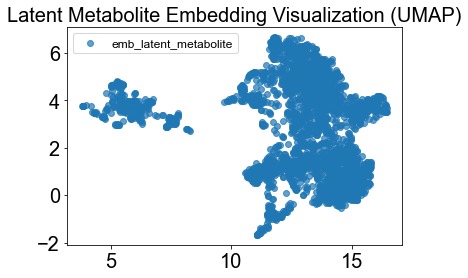

In [15]:
# Initialize the UMAP reducer
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Perform UMAP dimensionality reduction
reduced_latent_metabolite_umap = umap_reducer.fit_transform(emb_latent_metabolite)

# Plot the UMAP embedding
plt.scatter(
    reduced_latent_metabolite_umap[:, 0],
    reduced_latent_metabolite_umap[:, 1],
    label="emb_latent_metabolite",
    alpha=0.7
)
plt.legend()
plt.title("Latent Metabolite Embedding Visualization (UMAP)")
plt.show()

# Store the UMAP embedding in adata if needed
adata = adata_filtered
adata.obsm["umap_latent_metabolite"] = reduced_latent_metabolite_umap


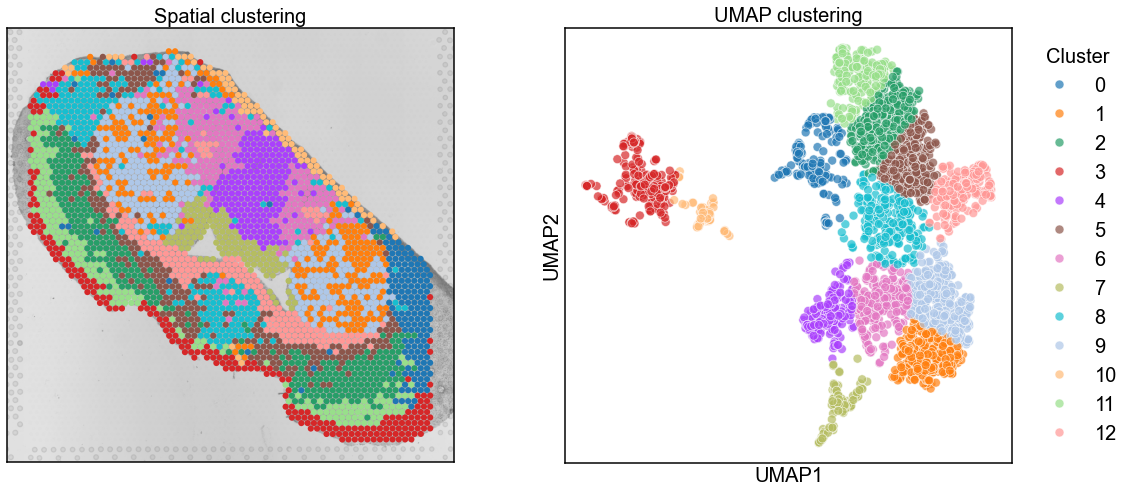

In [16]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 20

n_clusters = 13


X = adata.obsm['umap_latent_metabolite']

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
adata.obs['umap_based_clusters'] = clusters.astype(str)

palette = sc.pl.palettes.default_20[:n_clusters]


fig, axes = plt.subplots(
    1, 2,
    figsize=(18, 8),
    gridspec_kw={'wspace': 0.25}
)

# ======================
# Panel 1: Spatial clustering
# ======================
sc.pl.spatial(
    adata,
    color='umap_based_clusters',
    palette=palette,
    size=1.5,
    bw=True,
    alpha_img=0.6,
    ax=axes[0],
    show=False,
    legend_loc=None,
    title="Spatial clustering"
)

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')

for spine in axes[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# ======================
# Panel 2: UMAP scatter (Seaborn)
# ======================

sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=adata.obs['umap_based_clusters'],
    palette=palette,
    s=80,
    alpha=0.7,
    ax=axes[1],
    legend='full'
)

axes[1].set_title("UMAP clustering")
axes[1].set_xlabel("UMAP1")
axes[1].set_ylabel("UMAP2")
axes[1].set_xticks([])
axes[1].set_yticks([])

for spine in axes[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(
    handles,
    labels,
    title="Cluster",
    title_fontsize='medium',
    fontsize='medium',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)


plt.savefig(
    'SM_latent_spatial_umap.svg',
    format='svg',
    bbox_inches='tight'
)

plt.show()


In [17]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Embedding used for clustering evaluation
X = adata.obsm["umap_latent_metabolite"]

# Cluster assignments
labels = adata.obs["umap_based_clusters"].astype(int)

# Silhouette score
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Calinski–Harabasz index
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

# Davies–Bouldin index
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.3f}")

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Filter out spots with missing RegionLoupe annotations
valid_idx = adata_filtered.obs["RegionLoupe"].notnull()

# Agreement with region annotations
ARI_region = adjusted_rand_score(
    adata_filtered.obs.loc[valid_idx, "RegionLoupe"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)
NMI_region = normalized_mutual_info_score(
    adata_filtered.obs.loc[valid_idx, "RegionLoupe"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)

# Agreement with cell-type annotations
ARI_celltype = adjusted_rand_score(
    adata_filtered.obs.loc[valid_idx, "Cell type"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)
NMI_celltype = normalized_mutual_info_score(
    adata_filtered.obs.loc[valid_idx, "Cell type"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)

print(f"Region ARI: {ARI_region:.3f}, NMI: {NMI_region:.3f}")
print(f"Cell type ARI: {ARI_celltype:.3f}, NMI: {NMI_celltype:.3f}")


Silhouette Score: 0.432
Calinski-Harabasz Index: 5891.485
Davies-Bouldin Index: 0.750
Region ARI: 0.203, NMI: 0.395
Cell type ARI: 0.168, NMI: 0.334


## SHINE latent embedding

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


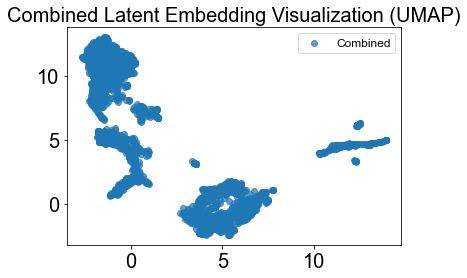

In [18]:
# Initialize the UMAP reducer
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Perform UMAP dimensionality reduction on the combined latent embedding
reduced_combined_umap = umap_reducer.fit_transform(emb_combined)

# Plot the UMAP embedding
plt.scatter(
    reduced_combined_umap[:, 0],
    reduced_combined_umap[:, 1],
    label="Combined",
    alpha=0.7
)
plt.legend()
plt.title("Combined Latent Embedding Visualization (UMAP)")
plt.show()

# Store the UMAP embedding in the AnnData object if needed
adata = adata_filtered
adata.obsm["umap_combined"] = reduced_combined_umap


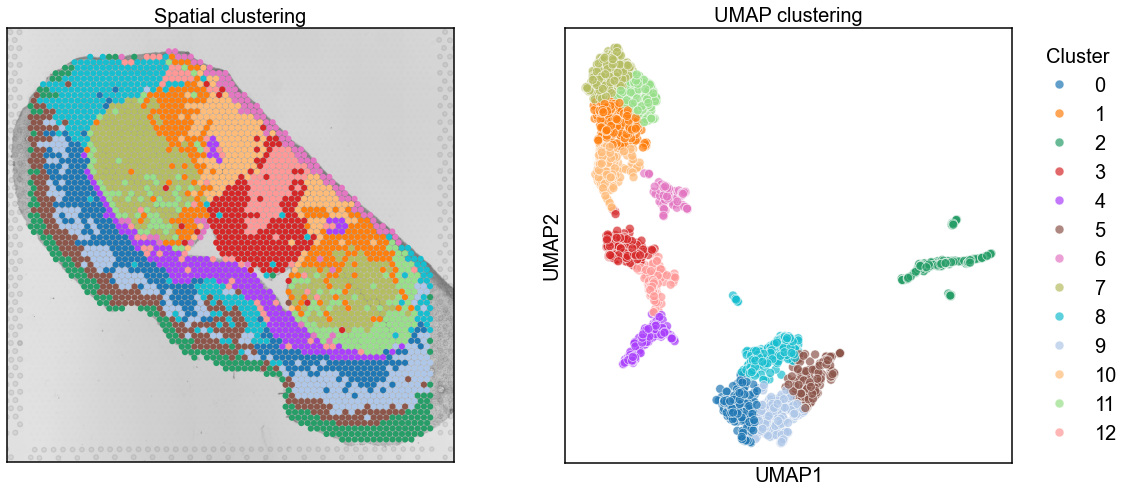

In [19]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 20

n_clusters = 13

X = adata.obsm['umap_combined']

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
adata.obs['umap_based_clusters'] = clusters.astype(str)

palette = sc.pl.palettes.default_20[:n_clusters]

fig, axes = plt.subplots(
    1, 2,
    figsize=(18, 8),
    gridspec_kw={'wspace': 0.25}
)

# ======================
# Panel 1: Spatial clustering
# ======================
sc.pl.spatial(
    adata,
    color='umap_based_clusters',
    palette=palette,
    size=1.5,
    bw=True,
    alpha_img=0.6,
    ax=axes[0],
    show=False,
    legend_loc=None,
    title="Spatial clustering"
)

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')

for spine in axes[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# ======================
# Panel 2: UMAP scatter (Seaborn)
# ======================
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=adata.obs['umap_based_clusters'],
    palette=palette,
    s=80,
    alpha=0.7,
    ax=axes[1],
    legend='full'
)

axes[1].set_title("UMAP clustering")
axes[1].set_xlabel("UMAP1")
axes[1].set_ylabel("UMAP2")
axes[1].set_xticks([])
axes[1].set_yticks([])

for spine in axes[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(
    handles,
    labels,
    title="Cluster",
    title_fontsize='medium',
    fontsize='medium',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.savefig(
    'SHINE_latent_spatial_umap.svg',
    format='svg',
    bbox_inches='tight'
)

plt.show()


<ipython-input-20-d941e5e5b3d4>:58: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


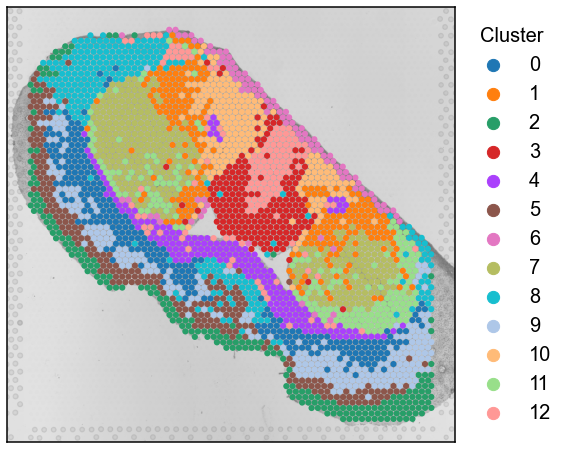

In [20]:
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Set font family and font sizes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 20

# Number of clusters
n_clusters = 13

# Perform clustering
X = adata.obsm["umap_combined"]
# kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
adata.obs["umap_based_clusters"] = clusters.astype(str)

# Define color palette
palette = sc.pl.palettes.default_20[:n_clusters]

# Create figure and axis
fig, ax = plt.subplots(figsize=(9, 8))

# Spatial visualization with grayscale background and adjusted transparency
sc.pl.spatial(
    adata,
    color="umap_based_clusters",
    palette=palette,
    size=1.5,
    bw=True,
    alpha_img=0.6,
    ax=ax,
    show=False,
    legend_loc="right margin",
    legend_fontsize="medium",
    title=""
)

# Remove axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

# Draw a clear outer frame
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color("black")

# Manually increase the size of colored dots in the legend
legend = ax.get_legend()
if legend is not None:
    legend.set_title("Cluster")
    legend.get_title().set_fontsize("medium")
    for handle in legend.legendHandles:
        handle.set_sizes([150])  # Increase marker size in the legend

# Save the figure (vector format recommended for publication)
plt.savefig("SHINE.svg", format="svg", bbox_inches="tight")

# Display the figure
plt.show()


In [21]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Embedding used for clustering evaluation
X = adata.obsm["umap_combined"]

# Cluster assignments
labels = adata.obs["umap_based_clusters"].astype(int)

# Silhouette score
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Calinski–Harabasz index
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

# Davies–Bouldin index
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.3f}")

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Filter out spots with missing RegionLoupe annotations
valid_idx = adata_filtered.obs["RegionLoupe"].notnull()

# Agreement with region annotations
ARI_region = adjusted_rand_score(
    adata_filtered.obs.loc[valid_idx, "RegionLoupe"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)
NMI_region = normalized_mutual_info_score(
    adata_filtered.obs.loc[valid_idx, "RegionLoupe"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)

# Agreement with cell-type annotations
ARI_celltype = adjusted_rand_score(
    adata_filtered.obs.loc[valid_idx, "Cell type"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)
NMI_celltype = normalized_mutual_info_score(
    adata_filtered.obs.loc[valid_idx, "Cell type"],
    adata_filtered.obs.loc[valid_idx, "umap_based_clusters"],
)

print(f"Region ARI: {ARI_region:.3f}, NMI: {NMI_region:.3f}")
print(f"Cell type ARI: {ARI_celltype:.3f}, NMI: {NMI_celltype:.3f}")


Silhouette Score: 0.502
Calinski-Harabasz Index: 16798.195
Davies-Bouldin Index: 0.676
Region ARI: 0.306, NMI: 0.568
Cell type ARI: 0.270, NMI: 0.522


# Comparison

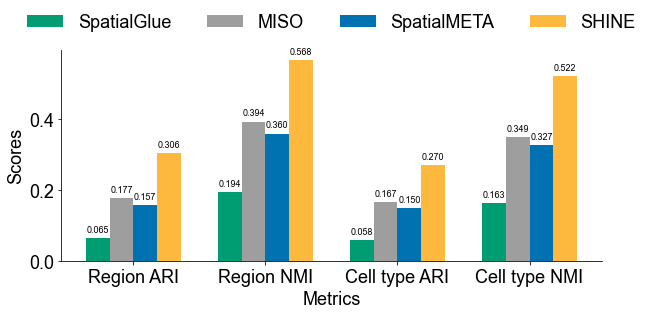

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Arial'

# -----------------------------
# Metrics and data
# -----------------------------
indicators = ['Region ARI', 'Region NMI', 'Cell type ARI', 'Cell type NMI']


SpatialGlue = [0.065, 0.194, 0.058, 0.163]
MISO = [0.177, 0.394, 0.167, 0.349]
SpatialMETA = [0.157, 0.360, 0.150, 0.327]
SHINE = [0.306,0.568,0.270,0.522]

methods = ['SpatialGlue', 'MISO', 'SpatialMETA', 'SHINE']

colors = [
    '#009D73',  
    '#9E9E9E',  
    '#0072B2',  
    '#FCB93E'   
]

data = np.array([SpatialGlue, MISO, SpatialMETA, SHINE])

# -----------------------------
# Figure canvas
# -----------------------------
x = np.arange(len(indicators))
width = 0.18

fig, ax = plt.subplots(figsize=(9.5, 5))

# -----------------------------
# Bar plot
# -----------------------------
rects = []
for i, method in enumerate(methods):
    rect = ax.bar(
        x + (i - (len(methods) - 1) / 2) * width,
        data[i],
        width,
        label=method,
        color=colors[i]
    )
    rects.append(rect)

# -----------------------------
# Axes labels and ticks
# -----------------------------
ax.set_xlabel('Metrics', fontsize=18)
ax.set_ylabel('Scores', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(indicators, fontsize=18)
ax.tick_params(axis='y', labelsize=18)

ax.legend(
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=4,
    frameon=False
)

# -----------------------------
# Simplify axes spines
# -----------------------------
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# -----------------------------
# Value annotations
# -----------------------------
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height:.3f}',
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 4),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=9,
            fontfamily='Arial'
        )

for rect_group in rects:
    autolabel(rect_group)

fig.tight_layout()

# -----------------------------
# Save figure
# -----------------------------
plt.savefig(
    'metrics_comparison.svg',
    format='svg',
    bbox_inches='tight'
)

plt.show()
